Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
from astropy import wcs

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
from scipy.optimize import curve_fit

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

In [4]:
params = {
'g_weight2': 0.00045, 'g_plexp2': -2.,
'r_weight2': 0.00033, 'r_plexp2': -2.,
'z_alpha2': 17.650, 'z_beta2': 1.7, 'z_weight2': 0.0145,
}

outlier_ccd_list = ['N20', 'S8', 'S10', 'S18', 'S21', 'S27']
params_outlier = {'z_alpha2': 16, 'z_beta2': 2.3, 'z_weight2': 0.0095}

field = 'south'
region_name = 'decals_ngc'
pixscale = 0.262

-----------

In [25]:
# bands = ['g', 'r', 'z']
band = 'g'
vranges = {'g':0.01, 'r':0.01, 'z':0.03}

blobs = fits.getdata('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/metrics/148/blobs-1482p315.fits.gz')
maskbits = fits.getdata('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/coadd/148/1482p315/legacysurvey-1482p315-maskbits.fits.fz')
img = fits.getdata('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/coadd/148/1482p315/legacysurvey-1482p315-image-{}.fits.fz'.format(band))

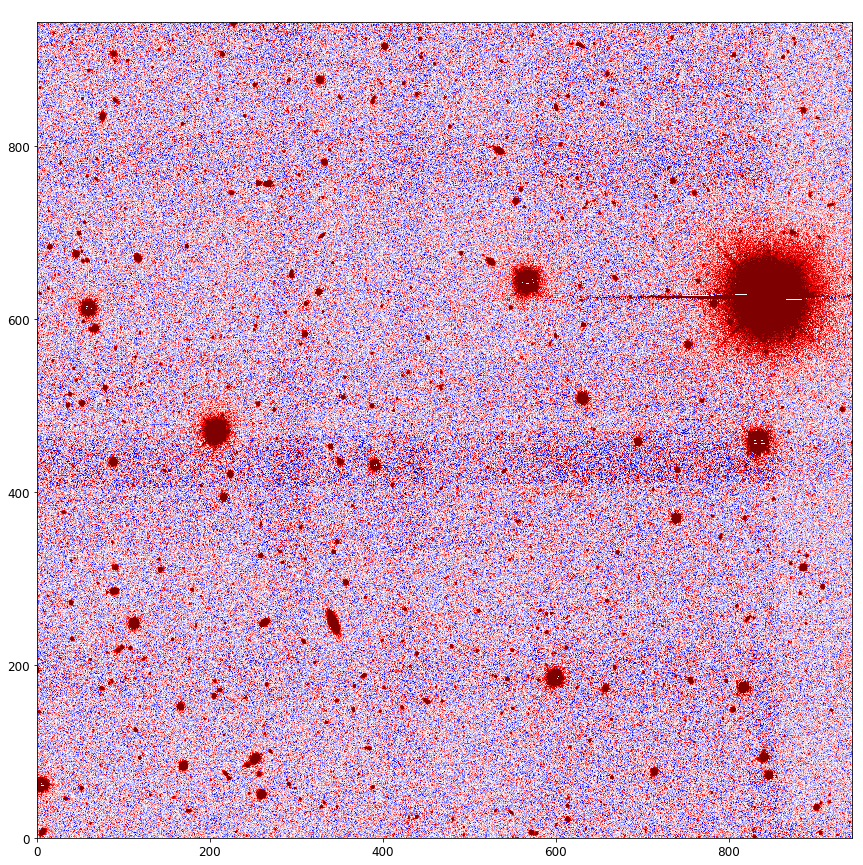

In [26]:
plt.figure(figsize=(16, 15))
plt.imshow(img, cmap='seismic', vmin=-vranges[band], vmax=vranges[band], origin='lower',
           extent=[0, 0.262*img.shape[1], 0, 0.262*img.shape[0]])
plt.title(' ')
plt.show()

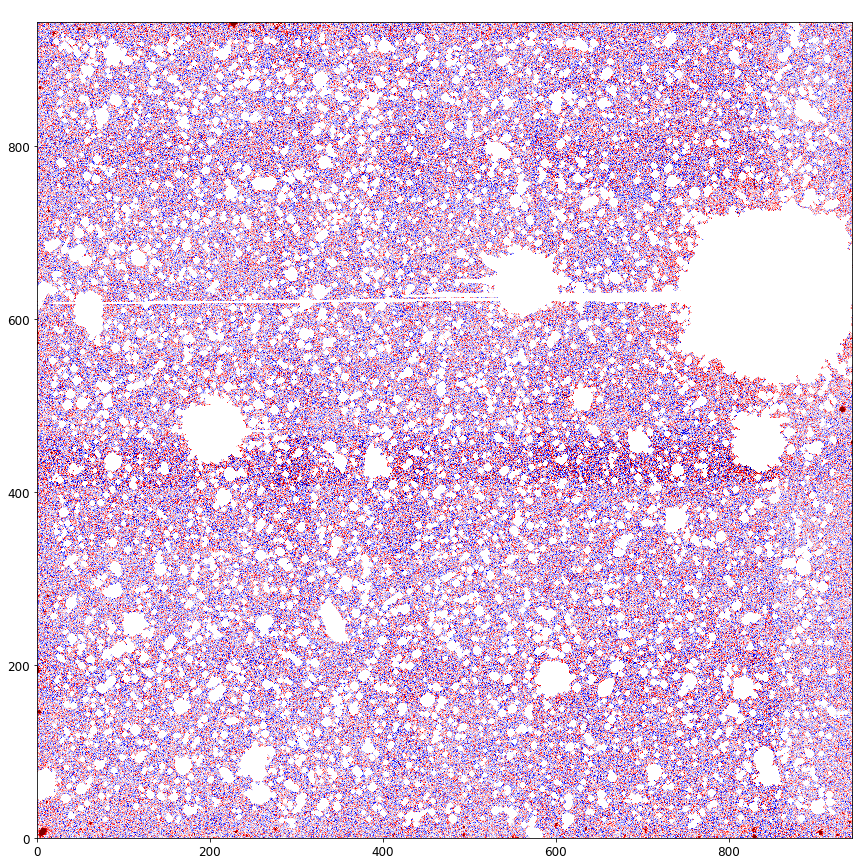

In [27]:
# correct for the sky offset and estimate the sky background level

mask = (blobs!=-1)
mask |= (maskbits&2**2>0) | (maskbits&2**3>0) | (maskbits&2**4>0)  # saturation
mask |= (maskbits&2**5>0) | (maskbits&2**6>0) | (maskbits&2**7>0)  # allmask
img1 = img.copy()
img1[mask] = np.nan

plt.figure(figsize=(16, 15))
plt.imshow(img1, cmap='seismic', vmin=-vranges[band], vmax=vranges[band], origin='lower',
           extent=[0, 0.262*img.shape[1], 0, 0.262*img.shape[0]])
plt.title(' ')
plt.show()

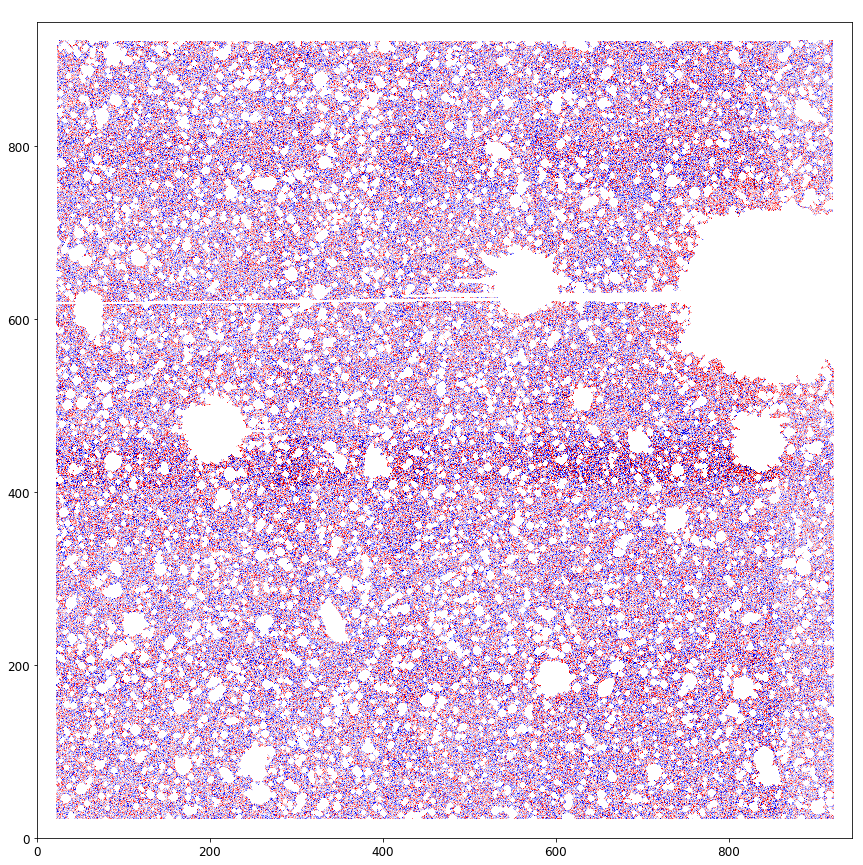

sky std  = 0.0023333
sky nmad = 0.0022874
sky median = -0.0000578


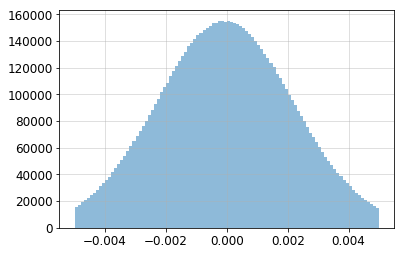

In [9]:
# correct for the sky offset and estimate the sky background level

mask = (blobs!=-1) | (maskbits&2**0>0)
mask |= (maskbits&2**2>0) | (maskbits&2**3>0) | (maskbits&2**4>0)  # saturation
mask |= (maskbits&2**5>0) | (maskbits&2**6>0) | (maskbits&2**7>0)  # allmask
img1 = img.copy()
img1[mask] = np.nan

plt.figure(figsize=(16, 15))
plt.imshow(img1, cmap='seismic', vmin=-vranges[band], vmax=vranges[band], origin='lower',
           extent=[0, 0.262*img.shape[1], 0, 0.262*img.shape[0]])
plt.title(' ')
plt.show()

sky_std = np.std(img1[np.isfinite(img1)])
sky_median = np.median(img1[np.isfinite(img1)])
nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
sky_nmad = nmad(img1[np.isfinite(img1)])
print('sky std  = {:.7f}'.format(sky_std))
print('sky nmad = {:.7f}'.format(sky_nmad))
print('sky median = {:.7f}'.format(sky_median))

plt.hist(img1[np.isfinite(img1)], 100, range=(-vranges[band]/2, vranges[band]/2), alpha=0.5)
plt.grid(alpha=0.5)
plt.show()

In [28]:
img = img - sky_median

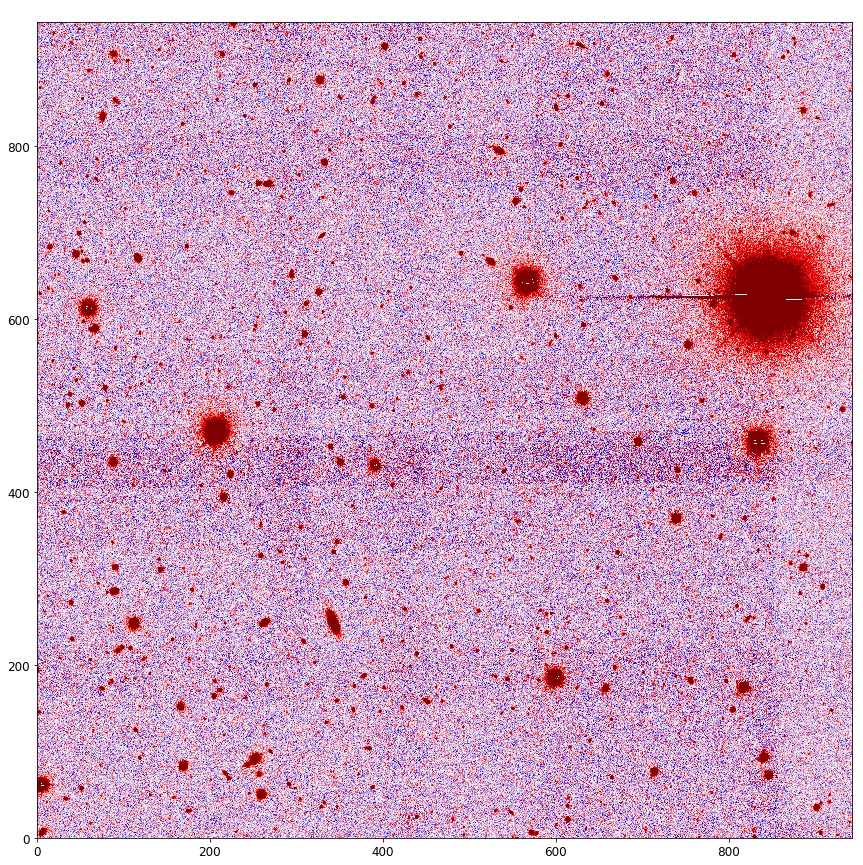

In [29]:
plt.figure(figsize=(16, 15))
plt.imshow(img, cmap='seismic', vmin=-vranges[band], vmax=vranges[band], origin='lower',
           extent=[0, 0.262*img.shape[1], 0, 0.262*img.shape[0]])
plt.title(' ')
plt.show()

In [10]:
# get WCS info
hdulist = fits.open('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/coadd/148/1482p315/legacysurvey-1482p315-image-g.fits.fz')
w = wcs.WCS(hdulist[1].header)

In [11]:
def get_ls_mag(gaia_g, gaia_bp, gaia_rp):
    # GAIA-LS transformation
    from scipy.interpolate import interp1d
    transform_interp = {}
    ls_mag = {}
    for bandtmp in ['g', 'r', 'z']:
        if field=='north':
            tmp = Table.read('/global/homes/r/rongpu/notebooks/bright_star_profiles/data/gaia_bassmzls_transform.txt', format='ascii.commented_header')
        else:
            tmp = Table.read('/global/homes/r/rongpu/notebooks/bright_star_profiles/data/gaia_decals_transform.txt', format='ascii.commented_header')
        transform_interp[bandtmp] = interp1d(tmp['bp_rp'], tmp['ls_'+bandtmp], bounds_error=False, fill_value='extrapolate', kind='linear')
        ls_mag[bandtmp] = gaia_g + transform_interp[bandtmp](gaia_bp-gaia_rp)
    return ls_mag

In [12]:
ra, dec = 148.12184029623234, 31.54267097002469
gaia_g, gaia_bp, gaia_rp = 7.46, 7.96, 6.84
print(gaia_bp-gaia_rp)
ls_mag = get_ls_mag(gaia_g, gaia_bp, gaia_rp)
print(ls_mag)
norm_factor =  10**((ls_mag[band]-22.5)/2.5)

1.12
{'g': 8.0268906841028365, 'r': 7.3285692018820381, 'z': 7.0230995308657196}


In [13]:
x, y = w.wcs_world2pix([[ra, dec]], 0)[0]
star_blob_idx = blobs[int(y), int(x)]

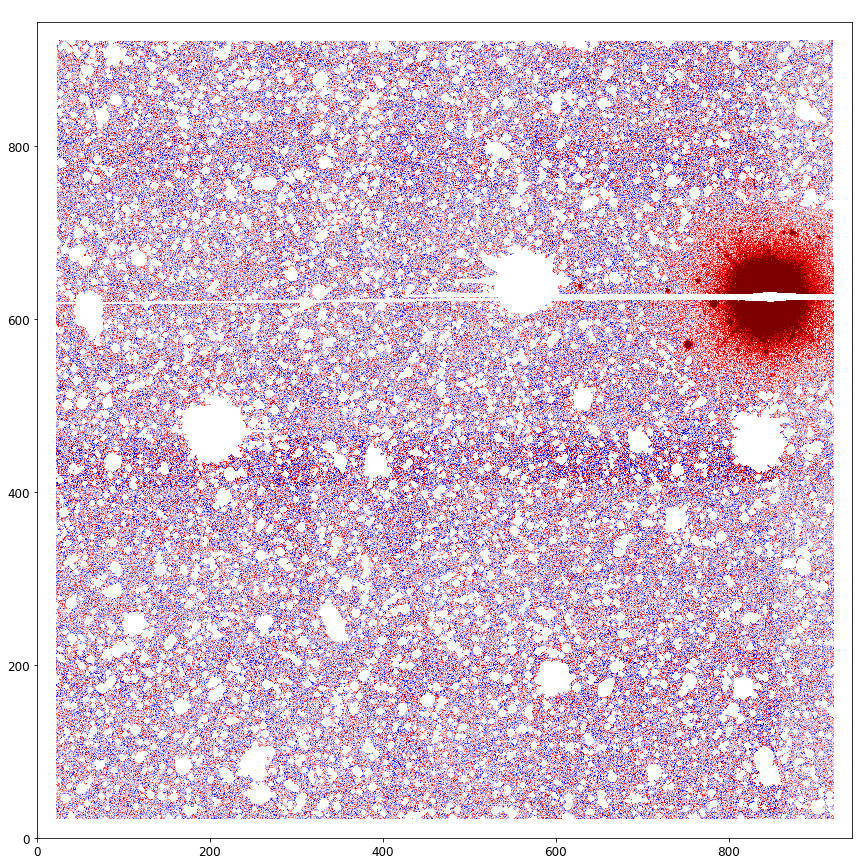

In [14]:
mask_blob = ((blobs!=-1) & (blobs!=star_blob_idx)) | (maskbits&2**0>0)
mask_blob |= (maskbits&2**2>0) | (maskbits&2**3>0) | (maskbits&2**4>0)  # saturation
mask_blob |= (maskbits&2**5>0) | (maskbits&2**6>0) | (maskbits&2**7>0)  # allmask
img1 = img.copy()
img1[mask_blob] = np.nan

plt.figure(figsize=(16, 15))
plt.imshow(img1, cmap='seismic', vmin=-vranges[band], vmax=vranges[band], origin='lower',
           extent=[0, 0.262*img.shape[1], 0, 0.262*img.shape[0]])
plt.title(' ')
plt.show()

In [15]:
# compute the ra and dec for each and every pixel
print(w.all_pix2world([[x, y]], 0)) # sanity check

gridx, gridy = np.arange(img.shape[1]), np.arange(img.shape[0])
xx, yy = np.meshgrid(gridx, gridy)
ra_pix, dec_pix = (w.all_pix2world(np.stack([xx.flatten(), yy.flatten()], axis=1), 0)).T
mask = ra_pix>355
ra_pix[mask] -= 360

# Sanity checks
# plt.figure(figsize=(16, 15))
# plt.imshow(dec_pix.reshape(img.shape), cmap='viridis', origin='lower')
# plt.colorbar()
# plt.title(' ')
# plt.show()
# plt.figure(figsize=(16, 15))
# plt.imshow(ra_pix.reshape(img.shape), cmap='viridis', origin='lower')
# plt.colorbar()
# plt.title(' ')
# plt.show()

# radius = radius_grid.flatten()

[[ 148.1218403    31.54267097]]


In [16]:
from astropy import units as u
from astropy.coordinates import SkyCoord

sky_pix = SkyCoord(ra_pix*u.degree, dec_pix*u.degree, frame='icrs')
sky_star = SkyCoord(ra*u.degree, dec*u.degree, frame='icrs')
radius = sky_star.separation(sky_pix)
radius = radius.to_value('arcsec')
radius_grid = radius.reshape(img.shape)

In [17]:
radius_plot = np.logspace(-1, 3, 1000)
if band=='z' and (ccdname in outlier_ccd_list):
    params_to_use = params_outlier
else:
    params_to_use = params
if band!='z':
    plexp2, weight2 = params_to_use[band+'_plexp2'], params_to_use[band+'_weight2']
    img_predict = weight2 * pixscale**2 * radius_grid**(plexp2) / norm_factor
    flux_plot = weight2 * pixscale**2 * radius_plot**(plexp2)
else:
    alpha2, beta2, weight2 = params_to_use[band+'_alpha2'], params_to_use[band+'_beta2'],  params_to_use[band+'_weight2']
    img_predict = weight2 * pixscale**2 * get_sb_moffat(radius_grid, alpha2, beta2) / norm_factor
    flux_plot = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

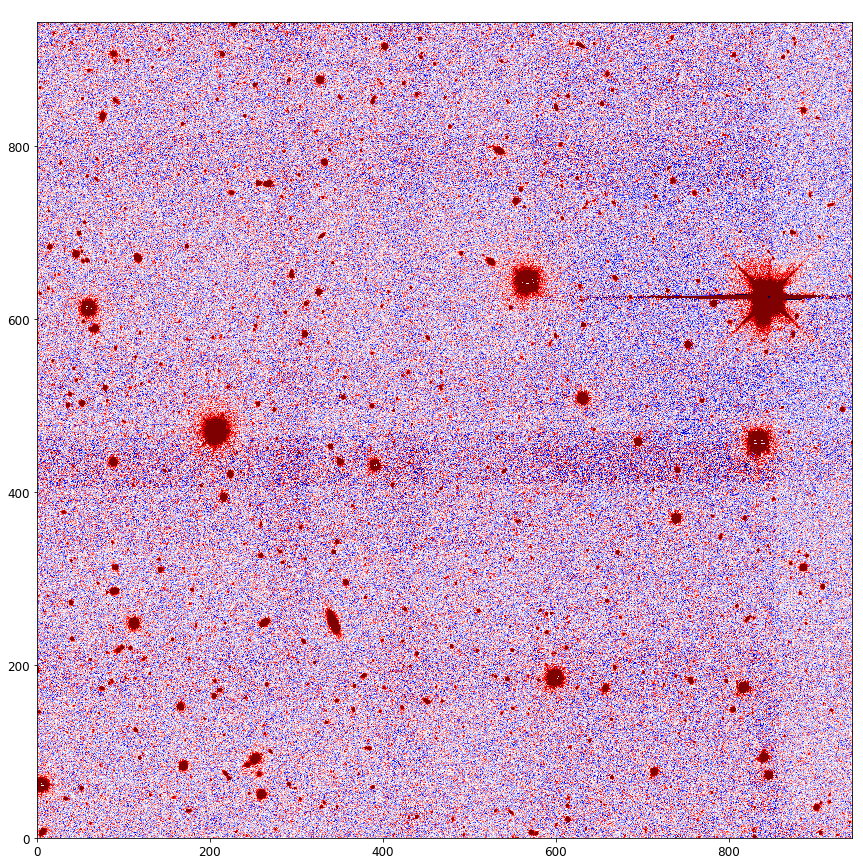

In [22]:
plt.figure(figsize=(16, 15))
plt.imshow(img-img_predict, cmap='seismic', vmin=-vranges[band], vmax=vranges[band], origin='lower', 
           extent=[0, 0.262*img.shape[1], 0, 0.262*img.shape[0]])
plt.title(' ')
plt.show()

In [19]:
def binned_stats(x, y, bins):
    bin_center, bin_median, bin_scatter = np.zeros((3, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        if np.sum(mask)>5:
            bin_center[index] = np.median(x[mask])
            bin_median[index] = np.median(y[mask])
            bin_scatter[index] = nmad(y[mask])
        else:
            bin_median[index], bin_scatter[index] = np.nan, np.nan
    return bin_center, bin_median, bin_scatter

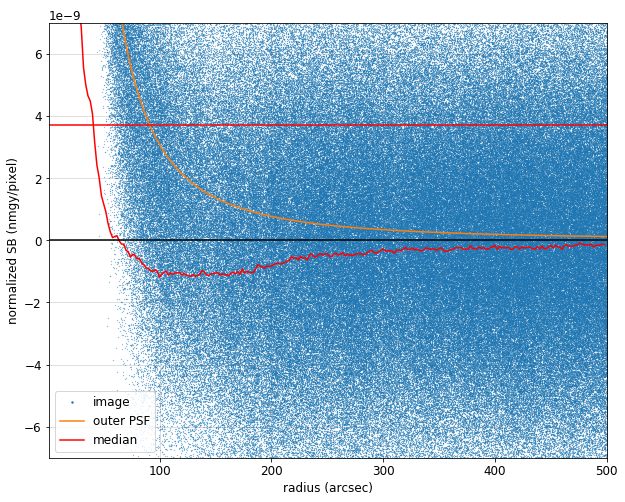

In [30]:
mask = (~mask_blob).flatten()
bin_center, bin_median, bin_scatter = binned_stats(radius[mask], ((img-img_predict).flatten())[mask], bins=np.arange(1, 500, 2))

plt.figure(figsize=(10, 8))
plt.plot((radius[mask])[::10], norm_factor*(img.flatten()[mask])[::10], '.', ms=0.4, label='image')
plt.plot(radius_plot, flux_plot, '-', lw=1.5, label='outer PSF')
plt.plot(bin_center, norm_factor*bin_median, '-', lw=1.5, color='r', label='median')
plt.axis([1, 500, -7e-9, 7e-9])
plt.grid(alpha=0.5)
plt.title(' ')
# plt.title('{}-band  decam_{}mag={:.2f}  {}-{}  alpha={:.2f}  beta={:.2f}'.format(band, band, gaia['ls_'+band][gaia_index], expnum_str, ccdname, alpha, beta))
plt.axhline(norm_factor*sky_nmad, color='r', lw=1.5)
plt.xlabel('radius (arcsec)')
plt.ylabel('normalized SB (nmgy/pixel)')
plt.legend(markerscale=7)
plt.axhline(0, color='k', lw=1.5)
plt.show()

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


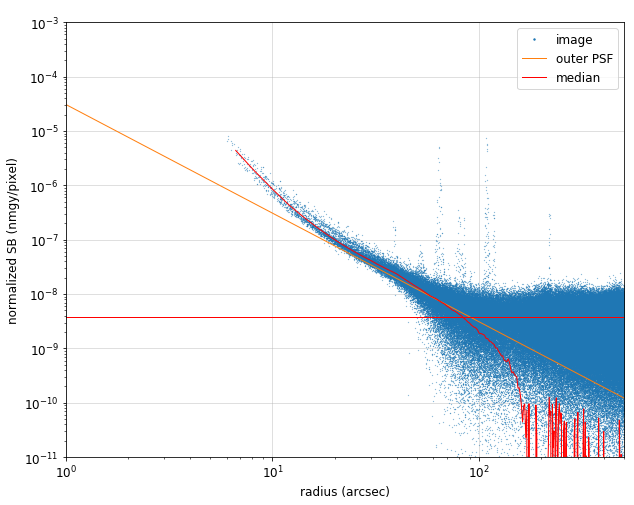

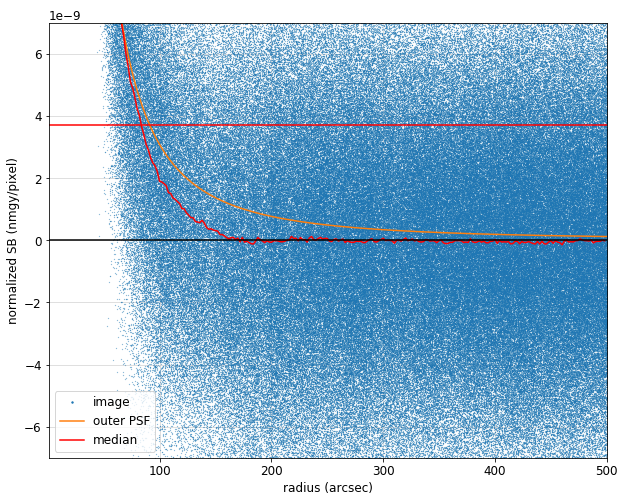

In [31]:
mask = (~mask_blob).flatten()
bin_center, bin_median, bin_scatter = binned_stats(radius[mask], (img.flatten())[mask], bins=np.arange(1, 500, 2))

plt.figure(figsize=(10, 8))
plt.loglog((radius[mask])[::10], norm_factor*(img.flatten()[mask])[::10], '.', ms=0.4, label='image')
plt.loglog(radius_plot, flux_plot, '-', lw=1, label='outer PSF')
plt.loglog(bin_center, norm_factor*bin_median, '-', lw=1, color='r', label='median')
plt.axis([1, 500, 1e-11, 0.001])
plt.grid(alpha=0.5)
plt.title(' ')
# plt.title('{}-band  decam_{}mag={:.2f}  {}-{}  alpha={:.2f}  beta={:.2f}'.format(band, band, gaia['ls_'+band][gaia_index], expnum_str, ccdname, alpha, beta))
plt.axhline(norm_factor*sky_nmad, color='r', lw=1)
plt.xlabel('radius (arcsec)')
plt.ylabel('normalized SB (nmgy/pixel)')
plt.legend(markerscale=7)
plt.show()

plt.figure(figsize=(10, 8))
plt.plot((radius[mask])[::10], norm_factor*(img.flatten()[mask])[::10], '.', ms=0.4, label='image')
plt.plot(radius_plot, flux_plot, '-', lw=1.5, label='outer PSF')
plt.plot(bin_center, norm_factor*bin_median, '-', lw=1.5, color='r', label='median')
plt.axis([1, 500, -7e-9, 7e-9])
plt.grid(alpha=0.5)
plt.title(' ')
# plt.title('{}-band  decam_{}mag={:.2f}  {}-{}  alpha={:.2f}  beta={:.2f}'.format(band, band, gaia['ls_'+band][gaia_index], expnum_str, ccdname, alpha, beta))
plt.axhline(norm_factor*sky_nmad, color='r', lw=1.5)
plt.xlabel('radius (arcsec)')
plt.ylabel('normalized SB (nmgy/pixel)')
plt.legend(markerscale=7)
plt.axhline(0, color='k', lw=1.5)
plt.show()